In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as disp
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler, DataLoader

import higher

In [ ]:
from data import TrainTestSplitter, CurveTasks

In [ ]:
# Device.
device = torch.device("cuda:0")

# Randomness.
np.random.seed(5)
torch.manual_seed(5)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Data.
tts = TrainTestSplitter(test_frac=0.4)
meta_train = CurveTasks(train_test_splitter=tts, meta_train=True)
meta_test = CurveTasks(train_test_splitter=tts, meta_train=False)

In [ ]:
# Model.
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.L1 = nn.Linear(1, 10)
        self.L2 = nn.Linear(10, 10)
        self.L3 = nn.Linear(10, 1)
    
    def forward(self, x):
        h1 = nn.Sigmoid()(self.L1(x))
        h2 = nn.Sigmoid()(self.L2(h1))
        out = self.L3(h2)
        return out

model = Model()

In [ ]:
def compute_mse(y, y_pred):
    return (y_pred - y)**2

In [ ]:
# Meta-train:
meta_epochs = 10
terminate_at_mb = 15
print_batch = False
random_sampling_order = False

if random_sampling_order:
    dl_meta_train = DataLoader(meta_train, sampler=RandomSampler(meta_train, replacement=False), batch_size=1)
    dl_meta_test = DataLoader(meta_test, sampler=RandomSampler(meta_test, replacement=False), batch_size=1)
else:
    dl_meta_train = DataLoader(meta_train, batch_size=1)
    dl_meta_test = DataLoader(meta_test,  batch_size=1)

lr_inner = 0.05
lr_outer = 0.05

n_iters_inner = 5

model = model.float()
opt_meta = torch.optim.Adam(model.parameters(), lr=lr_outer)

meta_train_losses = []
meta_test_losses = []
for meta_epoch in range(meta_epochs):
    print(f">> Meta-epoch: {meta_epoch}")
    
    me_train_losses = []
    me_test_losses = []
    
    # META-TRAINING:
    print("META-TRAINING...")
    for mtr_id, ((x_train, y_train), (x_test, y_test)) in enumerate(dl_meta_train):
        model.train()
        
        # Match data dtype to model; set the batch format for the model.
        (x_train, y_train), (x_test, y_test) = (x_train.float()[0], y_train.float()[0]), (x_test.float()[0], y_test.float()[0])
        
        # print(x_train[0]) To check we're sampling same / different items.
        
        opt_inner = torch.optim.SGD(model.parameters(), lr=lr_inner)
        
        opt_meta.zero_grad()
        
        test_losses = []
        with higher.innerloop_ctx(model, opt_inner, copy_initial_weights=False) as (functional_model, differentiable_optimiser):
            
            num_dp_train = len(x_train)
            for idx in range(num_dp_train):
                # Train fast model:
                for _ in range(n_iters_inner):
                    pred_fast = functional_model(x_train[idx].unsqueeze(0))
                    mse_fast = compute_mse(y_train[idx].squeeze(), pred_fast)
                    differentiable_optimiser.step(mse_fast)
            
            num_dp_test = len(x_test)
            for idx in range(num_dp_test):
                # Backprop slow model:
                pred_slow = functional_model(x_test[idx].unsqueeze(0))
                mse_slow = compute_mse(y_test[idx].squeeze(), pred_slow)
                test_losses.append(mse_slow.detach())
                mse_slow.backward(retain_graph=True)
            
        opt_meta.step()
        test_loss = sum(test_losses) / num_dp_test
        
        if print_batch:
            print(f"Meta-epoch: {meta_epoch + 1} / Meta-batch: {mtr_id + 1} | Test set loss: {test_loss.item():.5f}")
        me_train_losses.append(test_loss.item())
        
        if terminate_at_mb is not None and mtr_id == terminate_at_mb:
            break
    
    # META-TESTING:
    print("META-TESTING...")
    for mtr_id, ((x_train, y_train), (x_test, y_test)) in enumerate(dl_meta_test):
        model.eval()
        
        # Match data dtype to model; set the batch format for the model.
        (x_train, y_train), (x_test, y_test) = (x_train.float()[0], y_train.float()[0]), (x_test.float()[0], y_test.float()[0])
        
        opt_inner = torch.optim.SGD(model.parameters(), lr=lr_inner)
        
        test_losses = []
        with higher.innerloop_ctx(model, opt_inner, copy_initial_weights=False) as (functional_model, differentiable_optimiser):
            
            num_dp_train = len(x_train)
            for idx in range(num_dp_train):
                # Train fast model:
                for _ in range(n_iters_inner):
                    pred_fast = functional_model(x_train[idx].unsqueeze(0))
                    mse_fast = compute_mse(y_train[idx].squeeze(), pred_fast)
                    differentiable_optimiser.step(mse_fast)
            
            num_dp_test = len(x_test)
            for idx in range(num_dp_test):
                # Backprop slow model:
                pred_slow = functional_model(x_test[idx].unsqueeze(0)).detach()
                mse_slow = compute_mse(y_test[idx].squeeze(), pred_slow)
                test_losses.append(mse_slow.detach())
        
        test_loss = sum(test_losses) / num_dp_test
        
        if print_batch:
            print(f"Meta-epoch: {meta_epoch + 1} / Meta-batch: {mtr_id + 1} | Test set loss: {test_loss.item():.5f}")
        me_test_losses.append(test_loss.item())
        
        if terminate_at_mb is not None and mtr_id == terminate_at_mb:
            break
    
    me_train_loss = sum(me_train_losses) / len(me_train_losses)
    me_test_loss = sum(me_test_losses) / len(me_test_losses)    
    print(f">> Meta-epoch {meta_epoch}: TR = {me_train_loss:.5f}; TS = {me_test_loss:.5f}")
    
    meta_train_losses.append(me_train_loss)
    meta_test_losses.append(me_test_loss)    

>> Meta-epoch: 0
META-TRAINING...
META-TESTING...
>> Meta-epoch 0: TR = 0.04246; TS = 0.68977
>> Meta-epoch: 1
META-TRAINING...
META-TESTING...
>> Meta-epoch 1: TR = 0.04161; TS = 0.66305
>> Meta-epoch: 2
META-TRAINING...
META-TESTING...
>> Meta-epoch 2: TR = 0.03664; TS = 0.66105
>> Meta-epoch: 3
META-TRAINING...
META-TESTING...
>> Meta-epoch 3: TR = 0.03640; TS = 0.61810
>> Meta-epoch: 4
META-TRAINING...
META-TESTING...
>> Meta-epoch 4: TR = 0.03433; TS = 0.59346
>> Meta-epoch: 5
META-TRAINING...
META-TESTING...
>> Meta-epoch 5: TR = 0.03236; TS = 0.55616
>> Meta-epoch: 6
META-TRAINING...
META-TESTING...
>> Meta-epoch 6: TR = 0.03041; TS = 0.52634
>> Meta-epoch: 7
META-TRAINING...
META-TESTING...
>> Meta-epoch 7: TR = 0.02839; TS = 0.53225
>> Meta-epoch: 8
META-TRAINING...
META-TESTING...
>> Meta-epoch 8: TR = 0.02714; TS = 0.50260
>> Meta-epoch: 9
META-TRAINING...
META-TESTING...
>> Meta-epoch 9: TR = 0.02709; TS = 0.53536


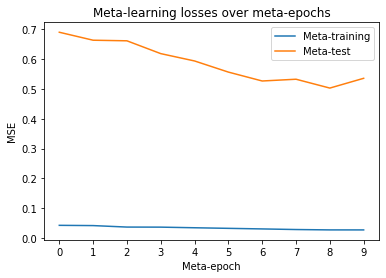

In [ ]:
# Plot.

def myplot(y1, y2):
    x = [str(int(_x)) for _x in list(range(len(y1)))]

    plt.plot(x, y1, y2)
    plt.title("Meta-learning losses over meta-epochs")
    plt.xlabel("Meta-epoch")
    plt.ylabel("MSE")

    plt.legend(["Meta-training", "Meta-test"])

myplot(meta_train_losses, meta_test_losses)